In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    print(dirname, len(filenames))
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input 0
/kaggle/input/chest-xray-pneumonia 0
/kaggle/input/chest-xray-pneumonia/chest_xray 0
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray 1
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val 1
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA 9
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/NORMAL 9
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/test 1
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/test/PNEUMONIA 390
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/test/NORMAL 234
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train 1
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA 3876
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL 1342
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX 1
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray 3
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/val 1
/kaggl

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [3]:
train_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/" 
val_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/"
test_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/test"

In [4]:
# Data Reading
import pathlib
data_dir = pathlib.Path(test_dir)
test_files = list(data_dir.glob("*/*.jpeg"))

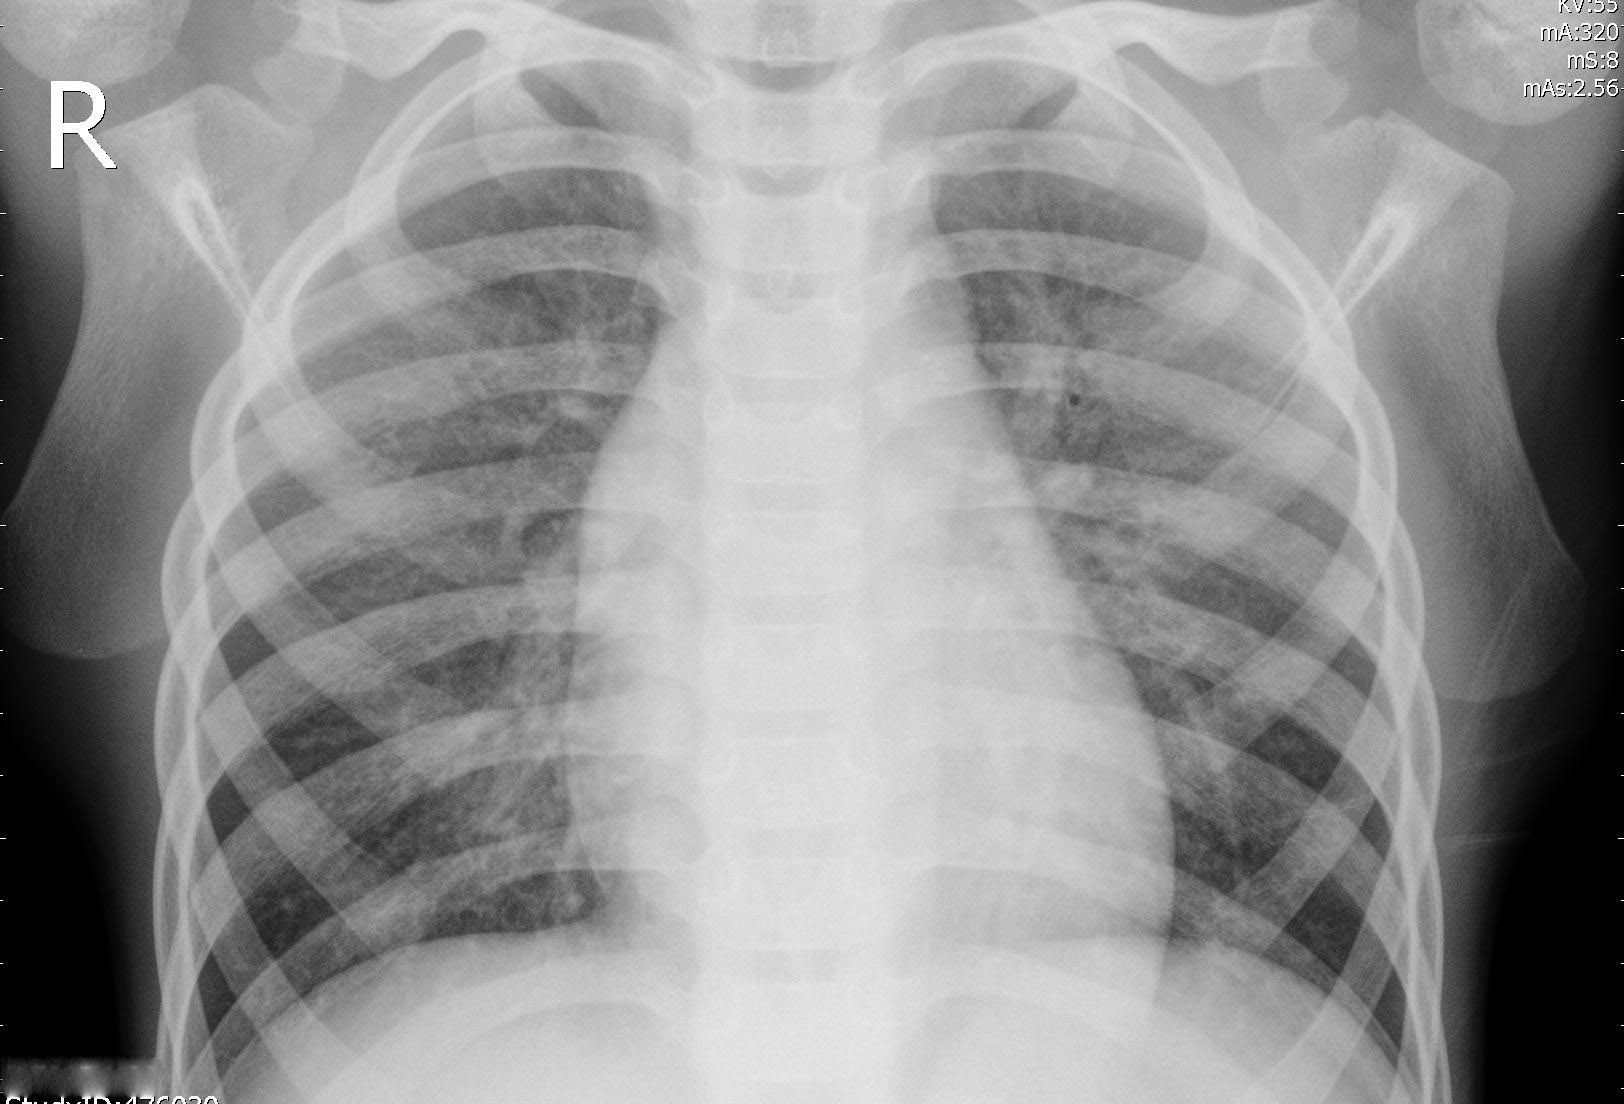

In [5]:
import PIL
import PIL.Image
PIL.Image.open(test_files[0])

In [6]:
batch_size = 32
image_width = 180
image_height = 180

In [7]:
train_ds = image_dataset_from_directory(train_dir,
                            seed=123,
                            image_size=(image_height, image_width),
                            batch_size=batch_size)

valid_ds = image_dataset_from_directory(val_dir,
                            seed=123,
                            image_size=(image_height, image_width),
                            batch_size=batch_size)

test_ds = image_dataset_from_directory(test_dir,
                            seed=123,
                            image_size=(image_height, image_width),
                            batch_size=batch_size)


Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


In [8]:
class_names = train_ds.class_names
print(class_names)

['NORMAL', 'PNEUMONIA']


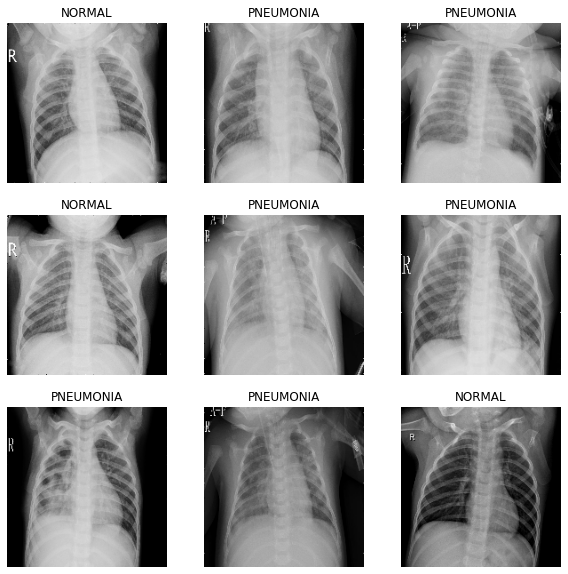

In [9]:
plt.figure(figsize=(10,10))
for images, lables in valid_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[lables[i]])
        plt.axis("off")


In [10]:
for images_batch, labels_batch in valid_ds:
    print(images_batch.shape)
    print(labels_batch.shape)
    break

(16, 180, 180, 3)
(16,)


In [11]:
def preprocess_input(ds):
    normalize = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
    ds = ds.map(lambda x,y: (normalize(x),y))
    return ds

In [12]:
train_ds = preprocess_input(train_ds)
valid_ds = preprocess_input(valid_ds)
test_ds = preprocess_input(test_ds)
images, labels = next(iter(test_ds))
image = images[0]
print(np.min(image), np.max(image))

0.0 1.0


In [13]:
# For speeding up trainings
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [14]:
num_classes = 2

model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [15]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [16]:
r = model.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=5
)

Epoch 1/5
163/163 [==============================] - 37s 208ms/step - loss: 0.6994 - accuracy: 0.7796 - val_loss: 0.5202 - val_accuracy: 0.7500
Epoch 2/5
163/163 [==============================] - 3s 15ms/step - loss: 0.1885 - accuracy: 0.9269 - val_loss: 0.5899 - val_accuracy: 0.6875
Epoch 3/5
163/163 [==============================] - 2s 15ms/step - loss: 0.1352 - accuracy: 0.9475 - val_loss: 0.4094 - val_accuracy: 0.6875
Epoch 4/5
163/163 [==============================] - 2s 15ms/step - loss: 0.1159 - accuracy: 0.9569 - val_loss: 0.2427 - val_accuracy: 0.8750
Epoch 5/5
163/163 [==============================] - 2s 15ms/step - loss: 0.1043 - accuracy: 0.9609 - val_loss: 0.3634 - val_accuracy: 0.7500


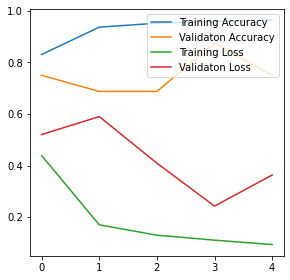

In [17]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.plot(r.history['accuracy'], label='Training Accuracy')
plt.plot(r.history['val_accuracy'], label='Validaton Accuracy')
plt.plot(r.history['loss'], label='Training Loss')
plt.plot(r.history['val_loss'], label='Validaton Loss')
plt.legend(loc='upper right')
plt.show()

In [18]:
model.evaluate(test_ds)

20/20 [==============================] - 3s 102ms/step - loss: 0.7327 - accuracy: 0.7901


[0.7327494025230408, 0.7900640964508057]

In [19]:
IMG_SHAPE = (image_height, image_width) + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [20]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 6, 6, 1280)


In [21]:
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 90, 90, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 90, 90, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 90, 90, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [22]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [23]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [24]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [25]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [26]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [27]:
model.evaluate(valid_ds)

1/1 [==============================] - 1s 1s/step - loss: 0.9140 - accuracy: 0.3750


[0.9139693975448608, 0.375]

In [28]:
r = model.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=5
)

Epoch 1/5
163/163 [==============================] - 6s 20ms/step - loss: 0.5334 - accuracy: 0.7059 - val_loss: 0.7359 - val_accuracy: 0.6250
Epoch 2/5
163/163 [==============================] - 3s 20ms/step - loss: 0.3501 - accuracy: 0.8783 - val_loss: 0.5804 - val_accuracy: 0.6875
Epoch 3/5
163/163 [==============================] - 3s 20ms/step - loss: 0.2694 - accuracy: 0.9156 - val_loss: 0.5073 - val_accuracy: 0.8125
Epoch 4/5
163/163 [==============================] - 3s 20ms/step - loss: 0.2265 - accuracy: 0.9233 - val_loss: 0.4658 - val_accuracy: 0.8125
Epoch 5/5
163/163 [==============================] - 3s 20ms/step - loss: 0.2000 - accuracy: 0.9296 - val_loss: 0.4380 - val_accuracy: 0.8750


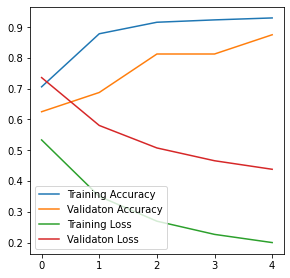

In [29]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.plot(r.history['accuracy'], label='Training Accuracy')
plt.plot(r.history['val_accuracy'], label='Validaton Accuracy')
plt.plot(r.history['loss'], label='Training Loss')
plt.plot(r.history['val_loss'], label='Validaton Loss')
plt.legend()
plt.show()

In [30]:
model.evaluate(test_ds)

20/20 [==============================] - 0s 19ms/step - loss: 0.4310 - accuracy: 0.8221


[0.43104055523872375, 0.8221153616905212]